# Model Validation

### Summary

To assess the realism of the model, selected variables were compared with reanalysis datasets (ERA5 and ORAS5) from periods consistent with the model’s simulated climate. The model uses a fixed atmospheric CO₂ concentration of 354 ppm, chosen to represent the effective radiative forcing conditions of the 2005–2015 period—despite being lower than actual CO₂ levels during that time—to account for the delayed temperature response of the climate system.

Radiative forcing is computed using the logarithmic relationship:
$$
\Delta F = \alpha\, \ln\left(\frac{\text{CO}_2}{{\text{CO}_2}_{\text{ref}}}\right)
$$
with $\alpha = 5.35\ \text{Wm}^{-2}$.

Model climatologies were computed over the last 15 years of a long-term simulation (100-member ensemble), and compared with reanalysis climatologies from ERA5 (2005–2015) and ORAS5 (2008–2012). Reanalysis data were interpolated to the model’s native T21 grid and land-sea mask to ensure consistent spatial comparison.

In [130]:
# Core Libraries
import numpy as np
import xarray as xr

# Plotting & Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Mapping & Geospatial Tools
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# Interpolation & Regridding
import xesmf as xe
from scipy.interpolate import griddata
import scipy.ndimage

# Statistics
from scipy.stats import pearsonr

In [131]:
# Custom color palette 
colors = ["darkblue","mediumblue", "royalblue", "cornflowerblue", "lightsteelblue", "aliceblue", "white", "mistyrose", "lightcoral", "indianred", "firebrick", "brown","maroon"]  # Adjust colors as needed
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

### Compute Model Climatologies (15-Year Average)

This block extracts and computes climatological means for selected variables from the model ensemble over 15 years. Each year includes 100 trajectories (ensemble members). For each variable, the code averages over time and then across ensemble members and years:

- ta (temperature at 850 hPa), psl (sea-level pressure) and u (zonal wind at 850 hPa) are extracted from the atmospheric dataset.
- sst (sea surface temperature) is taken from the ocean
- icec (sea ice cover) from ice model output files.

Final outputs:
- `sst_850_climatology_model`
- `u_850_climatology_model`
- `psl_climatology_model`
- `sst_climatology_model`
- `ice_cover_climatology_model`

These can now be used for validation against reanalysis data.


In [132]:
# Grid parameters
num_blocks = 15
num_members = 100
base_name = "TAU_LD_tau_pos_ntraj100_k0_LBlock360_p1_startIDl207-y2496_r2"
base_path = f"/home/magagna/analisiplasim3/{base_name}"

# Prepare arrays
sst_850_model = []
u_850_model = []
sst_model = []
ice_cover_model = []
psl_model = []

plev = None
latitude = None
longitude = None

for block in range(1, num_blocks + 1):
    temp850_block = []
    u850_block = []
    sst_block = []
    icecov_block = []
    psl_block = []

    for member in range(1, num_members + 1):
        suffix = f"{member:04d}.{block:04d}_light.nc"
        path = f"{base_path}/data/block_{block:04d}"
        
        # Load datasets
        ds = xr.open_dataset(f"{path}/{base_name}_data.{suffix}")
        ds_oce = xr.open_dataset(f"{path}/{base_name}_ocean.{suffix}")
        ds_ice = xr.open_dataset(f"{path}/{base_name}_ice.{suffix}")
        
        if plev is None:
            plev = ds["plev"]
            latitude = ds["lat"]
            longitude = ds["lon"]

        ta850 = ds["ta"][:, 0, :, :].mean(dim="time")
        temp850_block.append(ta850.values)

        u850 = ds["u"][:, 0, :, :].mean(dim="time")
        u850_block.append(u850.values)

        psl = ds["psl"].mean(dim="time")
        psl_block.append(psl.values)

        sst = ds_oce["sst"].mean(dim="time")
        sst_block.append(sst.values)

        icec = ds_ice["icec"].mean(dim="time")
        icecov_block.append(icec.values)

        ds.close()
        ds_oce.close()
        ds_ice.close()

    sst_850_model.append(np.stack(temp850_block))
    u_850_model.append(np.stack(u850_block))
    psl_model.append(np.stack(psl_block))
    sst_model.append(np.stack(sst_block))
    ice_cover_model.append(np.stack(icecov_block))

# Convert to arrays and compute climatology (averaging over axis 0 and 1 means averaging over members and blocks)
sst_850_model = np.stack(sst_850_model)
sst_850_climatology_model = np.mean(sst_850_model, axis=(0, 1))

u_850_model = np.stack(u_850_model)
u_850_climatology_model = np.mean(u_850_model, axis=(0, 1))

psl_model = np.stack(psl_model)
psl_climatology_model = np.mean(psl_model, axis=(0, 1))

sst_model = np.stack(sst_model)
sst_climatology_model = np.mean(sst_model, axis=(0, 1))

ice_cover_model = np.stack(ice_cover_model)
ice_cover_climatology_model = np.mean(ice_cover_model, axis=(0, 1))

### Compute Reanalysis Climatologies (10-Year Average)

This block extracts and computes climatological means for the same selected variables from the ERA5 reanalysis data over 10 years. 

Final outputs:
- `sst_850_climatology_era5`
- `u_850_climatology_era5`
- `psl_climatology_era5`
- `sst_climatology_era5`
- `ice_cover_climatology_era5`

In [133]:
# ERA5 Mean Sea Level Pressure (PSL)

file_psl = "/home/magagna/analisiplasim3/script_validation/era5_psl.nc"
ds_psl = xr.open_dataset(file_psl)

psl_climatology_era5 = ds_psl["msl"].mean(dim="valid_time").values
lat_era5 = ds_psl["latitude"]
lon_era5 = ds_psl["longitude"]

# ERA5 850 hPa Temperature and Wind

file_850 = "/home/magagna/analisiplasim3/script_validation/era5_850.nc"
ds_850 = xr.open_dataset(file_850)

sst_850_climatology_era5 = ds_850["t"][:, 0, :, :].mean(dim="valid_time").values
u_850_climatology_era5 = ds_850["u"][:, 0, :, :].mean(dim="valid_time").values
# (Reuses lat_era5 and lon_era5 if needed — no overwrite)

# ERA5 Surface SST and 10m Wind

file_surface = "./data_0.nc"
ds_surface = xr.open_dataset(file_surface)

sst_climatology_era5 = ds_surface["sst"].mean(dim="valid_time").values
u10_climatology_era5 = ds_surface["u10"].mean(dim="valid_time").values
# (Reuses lat_era5 and lon_era5 if needed — no overwrite)

# Land-Sea Mask

file_mask = "./lsm_1279l4_0.1x0.1.grb_v4_unpack.nc"
ds_mask = xr.open_dataset(file_mask)

mask = ds_mask["lsm"].mean(dim="time").values

# ERA5 Sea Ice Cover

file_ice = "/home/magagna/analisiplasim3/script_validation/seaicecover.nc"
ds_ice = xr.open_dataset(file_ice)
ice_cover_climatology_era5 = ds_ice.mean(dim="valid_time").to_array().values[0, :, :] # Collapse time dimension and extract 2D field

In global gridded datasets, longitude often ranges from 0° to 360°. However, when visualizing or performing calculations across this range, a discontinuity can appear at the edges — between 0° and 360° — even though they represent the same meridian.

To ensure seamless continuity across the global domain, we apply a technique called a cyclic point. This involves appending an additional data column at the end of the array, matching the values at the start (0°), and likewise extending the longitude coordinate by one step to wrap around to 360°.

If the longitude coordinate has not yet been modified, the function adds a cyclic point directly: the data field gains one column, and longitude gets a new point (e.g., from 64 to 65 values).

If the cyclic point has already been added (e.g., longitude is already length 65), the code ensures that a duplicate isn’t appended again. It resets longitude using the original dataset (ds["lon"]) and reapplies the cyclic point to maintain correctness.

In [134]:
def add_cyclic(field, longitude):    
    
    if longitude.size == 64 and field.size == 2048:
        field,longitude= add_cyclic_point(field, coord=longitude)

    elif longitude.size == 65 and field.size != 2080:
        longitude = ds["lon"]
        field,longitude= add_cyclic_point(field, coord=longitude)

    return(field, longitude)

In [135]:
sst_climatology_model, longitude = add_cyclic(sst_climatology_model, longitude)
sst_850_climatology_model, longitude = add_cyclic(sst_850_climatology_model, longitude)
psl_climatology_model, longitude = add_cyclic(psl_climatology_model, longitude)
u_850_climatology_model, longitude = add_cyclic(u_850_climatology_model, longitude)
ice_cover_climatology_model, longitude = add_cyclic(ice_cover_climatology_model, longitude)

To align ERA5 climatological data with the model resolution (32 latitudes × 65 longitudes), we define a resampling function using bilinear interpolation. This function applies efficient 2D resizing via scipy.ndimage.zoom

In [136]:
def resample_field(field, model_grid, method='bilinear'):
    """
    Resamples a 2D field to the desired shape using interpolation.

    Parameters:
    - field: 2D numpy array to be resampled
    - model_grid: tuple (target_rows, target_cols)
    - method: 'nearest', 'bilinear', or 'cubic'

    Returns:
    - Resampled field as a 2D numpy array
    """
    methods = {'nearest': 0, 'bilinear': 1, 'cubic': 3}
    if method not in methods:
        raise ValueError("Interpolation method must be 'nearest', 'bilinear', or 'cubic'")
    
    zoom_factors = (model_grid[0] / field.shape[0], model_grid[1] / field.shape[1])
    return scipy.ndimage.zoom(field, zoom_factors, order=methods[method])

In [137]:
model_grid = (32, 65)  # Your model grid

psl_climatology_era5_resampled = resample_field(psl_climatology_era5, model_grid)
sst_850_climatology_era5_resampled = resample_field(sst_850_climatology_era5, model_grid)
u_850_climatology_era5_resampled = resample_field(u_850_climatology_era5, model_grid)
sst_climatology_era5_resampled = resample_field(sst_climatology_era5, model_grid)
ice_cover_climatology_era5_resampled = resample_field(ice_cover_climatology_era5, model_grid)

# For the land-sea mask, assuming original shape (1801, 3600)
mask_resampled = resample_field(mask, model_grid)

# Bias Plots and Metrics

In order to have a normalized colorbar centered on zero and with a sensed spacing and ticks, I define a function which selects the maximum absolute value between positive and negative bias, then approximates it to the upper integer and defines levels spacing based on that.

In [138]:
def normalize(bias):
    x = max(np.nanmax(bias), abs(np.nanmin(bias)))
    y = int(np.ceil(x))

    if 2*y > 20 and 2*y < 30: 
        z = y + 1
    elif 2*y > 34:
        z = int(0.5 * y) + 1
        
    elif 2*y < 10:
        z = 4*y + 1
    else:
        z = 2*y + 1


    levels = np.linspace(-y, y, z)
    return levels

The following function computes the main metrics.

In [309]:
def compute_metrics(model, era5, diff, name='Field'):
    """
    Compute statistical metrics between model and ERA5 reference data.

    Parameters:
        model (np.ndarray): Model field data
        era5 (np.ndarray): Reference ERA5 data
        diff (np.ndarray): Difference between model and ERA5 (model - era5)
        name (str): Optional label for print context

    Returns:
        metrics (dict): Dictionary with MBE, RMSE, MAE, Pearson correlation, and p-value
    """
    mbe = np.nanmean(diff)
    rmse = np.sqrt(np.nanmean(diff**2))
    mae = np.nanmean(np.abs(diff))

    print(f"Metrics for {name}:")
    print(f"  Mean Bias Error (MBE): {mbe:.3f}")
    print(f"  Root Mean Square Error (RMSE): {rmse:.3f}")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}")

    corr, pval = pearsonr(era5.flatten(), model.flatten())
    
    if not np.isnan(corr):
        print(f"  Pearson Correlation: {corr:.3f} with a pvalue of {pval:.3f}")
    else:
        # Find valid (non-NaN) indices
        valid_mask = np.logical_and(~np.isnan(era5), ~np.isnan(model))

        # Apply mask to both datasets
        era5_valid = era5[valid_mask]
        model_valid = model[valid_mask]

        # Compute Pearson correlation
        corr, pval = pearsonr(era5_valid, model_valid)

        print(f"  Pearson Correlation (without NaNs): {corr:.3f} with a pvalue of {pval:.3f}")

And function to compute bin numbers. in order to have a consistent width.

In [280]:
def compute_bins(bin_width, bias):
    x = max(np.nanmax(bias), abs(np.nanmin(bias)))
    bins = np.arange(-x, x + bin_width, bin_width)
    return(bins)

### Sea Surface Temperature

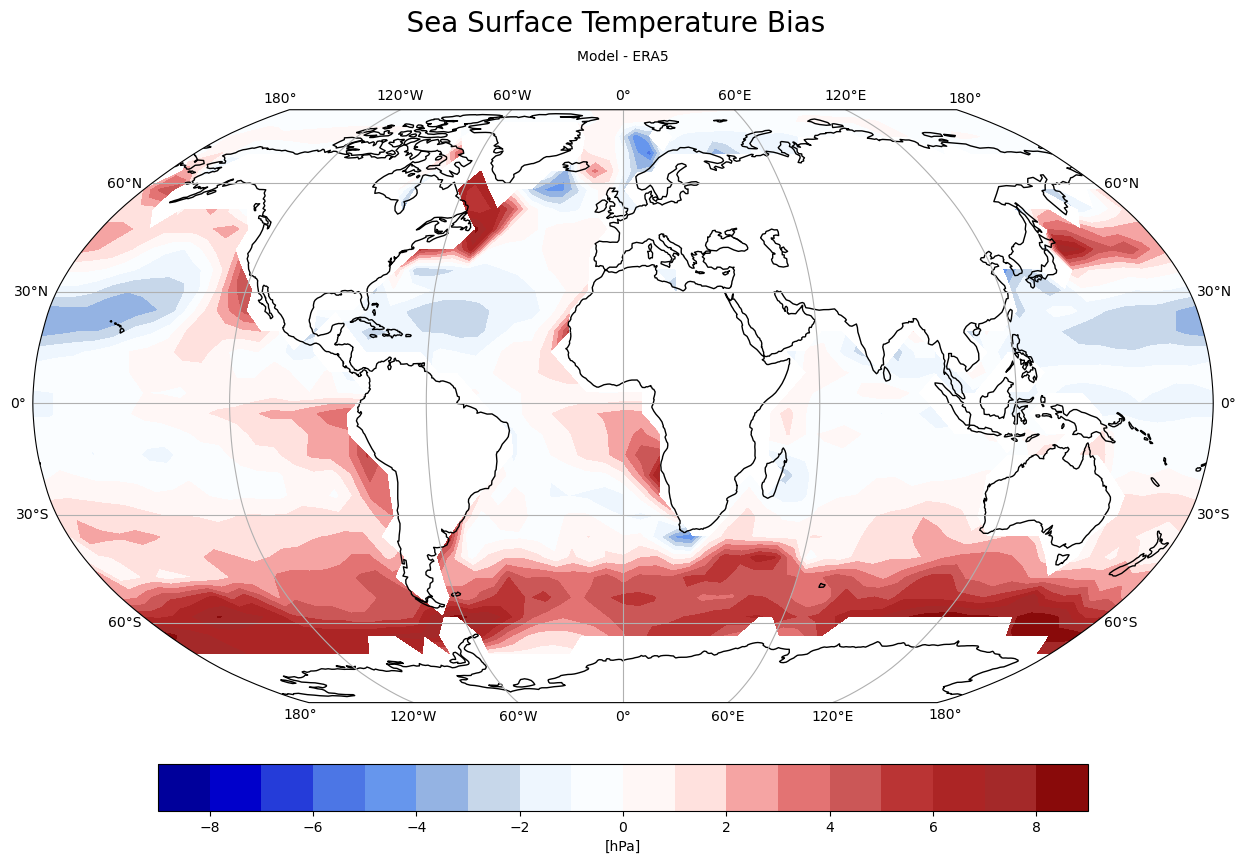

In [ ]:
sst_diff = (sst_climatology_model - sst_climatology_era5_resampled)

# SST plot
fig = plt.figure(figsize=(20, 10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()
axs.gridlines(draw_labels=True)

levels = normalize(sst_diff)

crs = plt.contourf(longitude, latitude, sst_diff, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap)
cbar = plt.colorbar(crs, location='bottom', shrink=0.6, pad =0.08)
cbar.set_label('[hPa]')

plt.suptitle('    Sea Surface Temperature Bias', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.show()

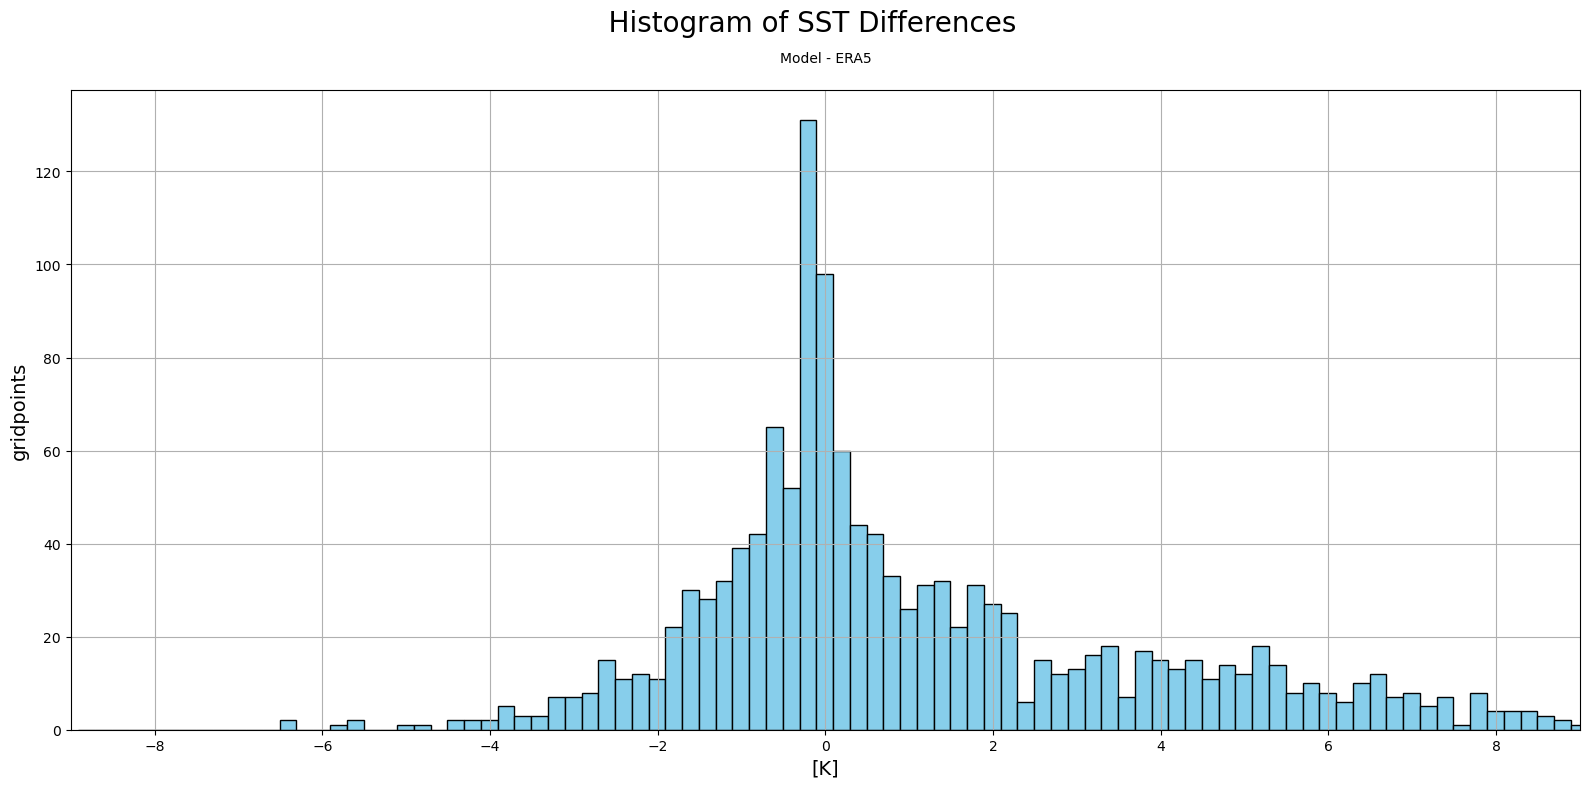

In [282]:
bins = compute_bins(0.2, sst_diff)

plt.figure(figsize=(16, 8))
plt.hist(sst_diff[~np.isnan(sst_diff)].flatten(), bins=bins, color='skyblue', edgecolor='k')
plt.suptitle('    Histogram of SST Differences', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.xlabel("[K]", fontsize=14)
plt.ylabel("gridpoints", fontsize=14)
plt.grid(True)
plt.xlim(-9, 9)
plt.tight_layout()
plt.show()

In [142]:
compute_metrics(model=sst_climatology_model, era5=sst_climatology_era5_resampled, diff=sst_diff, name='SST')

Metrics for SST:
  Mean Bias Error (MBE): 1.029
  Root Mean Square Error (RMSE): 2.823
  Mean Absolute Error (MAE): 1.953
  Pearson Correlation (without NaNs): 0.976 with a pvalue of 0.000


### 850 hPa Air Temperature

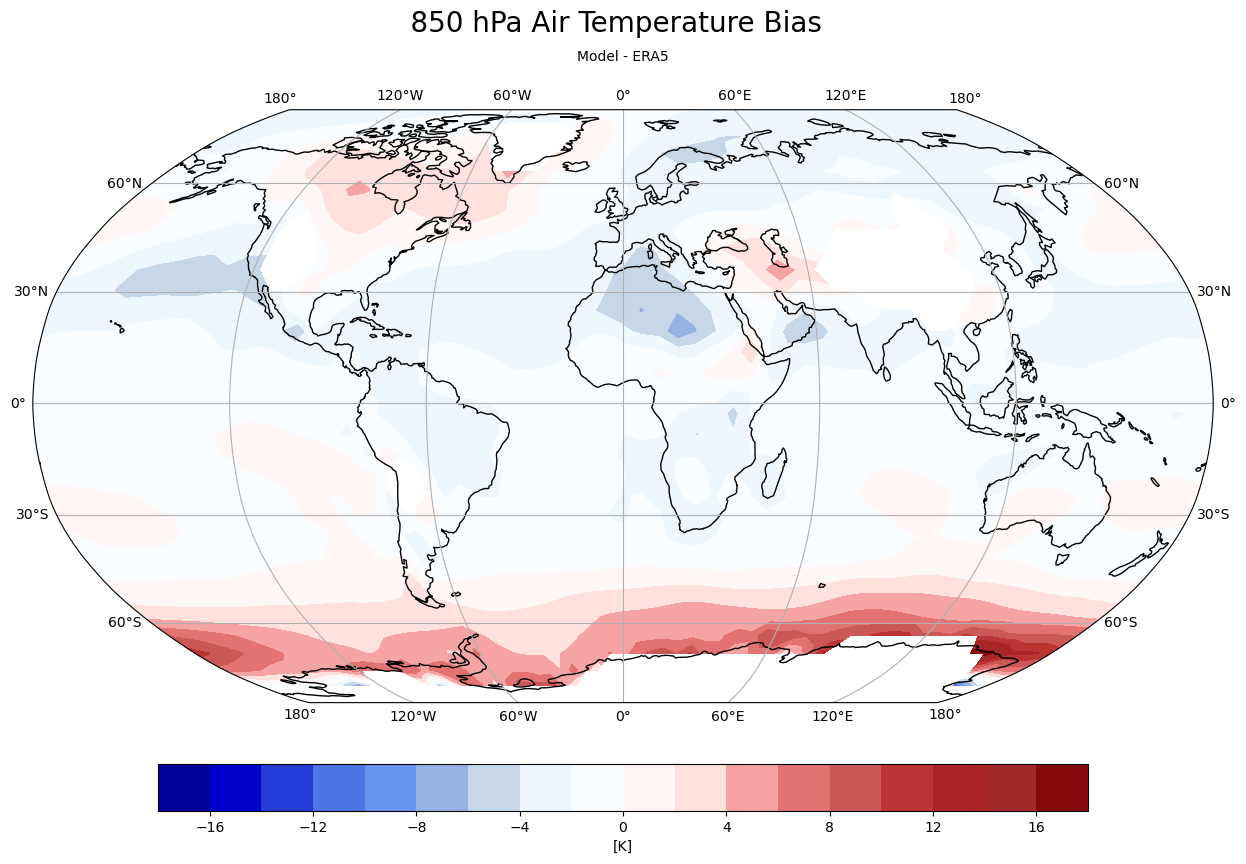

In [156]:
at_diff = (sst_850_climatology_model - sst_850_climatology_era5_resampled)

# SST plot
fig = plt.figure(figsize=(20, 10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()
axs.gridlines(draw_labels=True)

levels = np.linspace(-18,18,19)

crs = plt.contourf(longitude, latitude, at_diff, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap)
cbar = plt.colorbar(crs, location='bottom', shrink=0.6, pad =0.08)
cbar.set_label('[K]')

plt.suptitle('    850 hPa Air Temperature Bias', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.show()

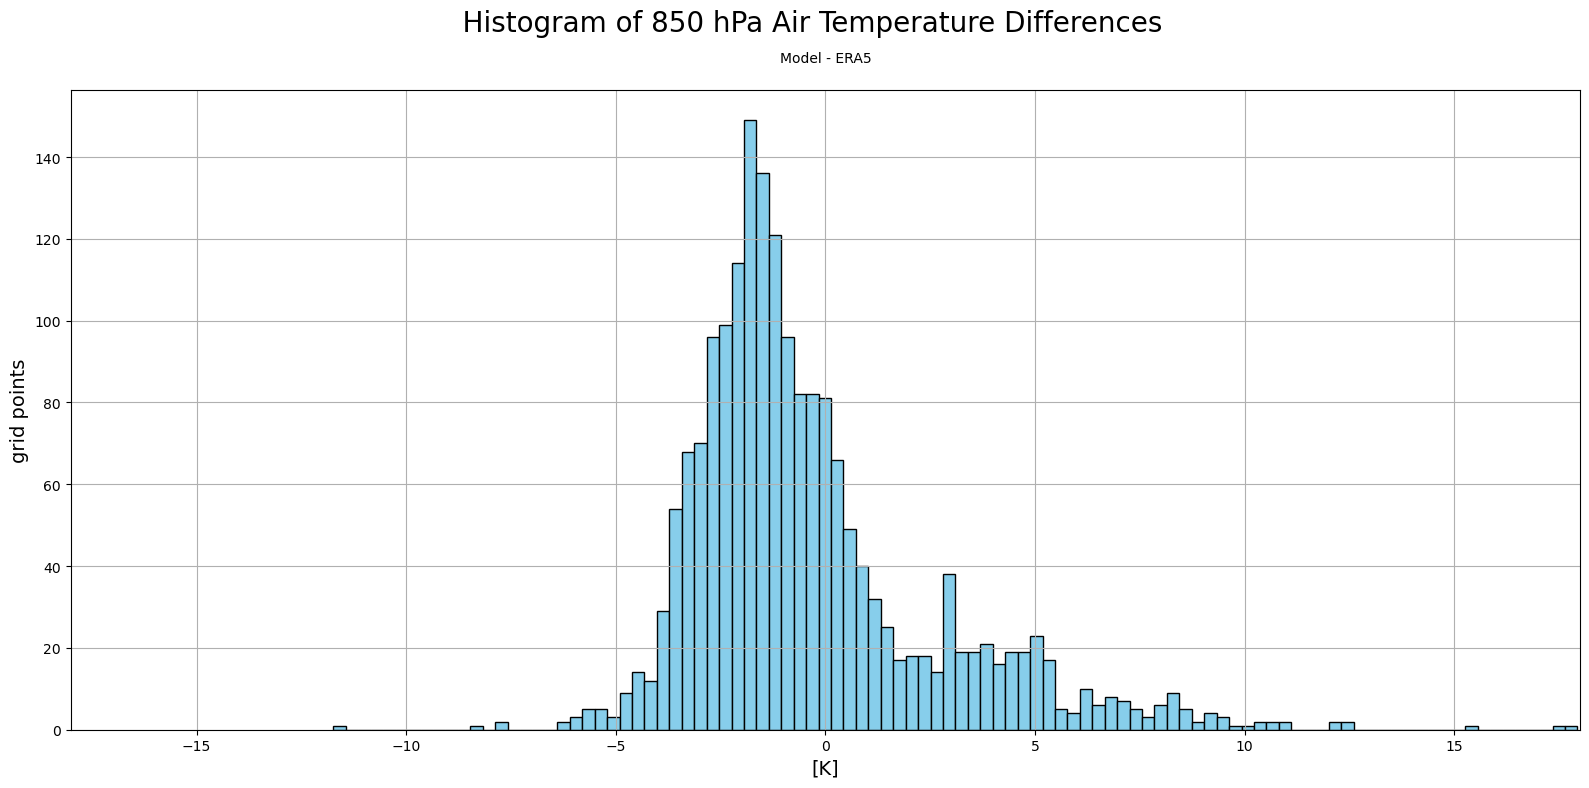

In [283]:
bins = compute_bins(0.2, at_diff)

plt.figure(figsize=(16, 8))
plt.hist(at_diff[~np.isnan(at_diff)].flatten(), bins=100, color='skyblue', edgecolor='k')
plt.suptitle('    Histogram of 850 hPa Air Temperature Differences', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.xlabel("[K]", fontsize=14)
plt.ylabel("grid points", fontsize=14)
plt.grid(True)
plt.xlim(-18, 18)
plt.tight_layout()
plt.show()

In [146]:
compute_metrics(model=sst_850_climatology_model, era5=sst_850_climatology_era5_resampled, diff=at_diff, name='850hPa Temperature')

Metrics for 850hPa Temperature:
  Mean Bias Error (MBE): -0.375
  Root Mean Square Error (RMSE): 3.013
  Mean Absolute Error (MAE): 2.304
  Pearson Correlation (without NaNs): 0.974 with a pvalue of 0.000


### Sea Level Pressure

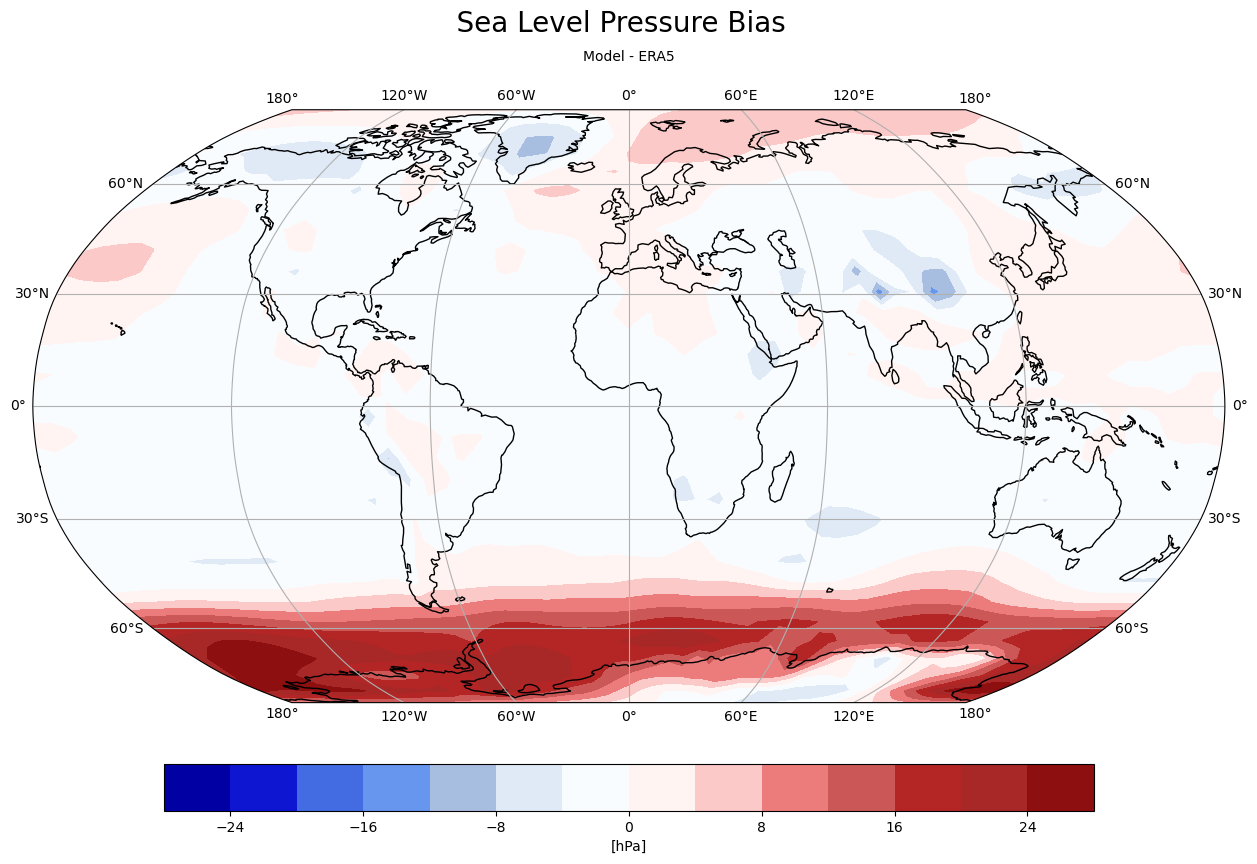

In [147]:
slp_diff = (psl_climatology_model - psl_climatology_era5_resampled)/100 # divide by 100 to convert to hPa

# SLP bias plot
fig = plt.figure(figsize=(20, 10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()
axs.gridlines(draw_labels=True)

levels = normalize(slp_diff)

crs = plt.contourf(longitude, latitude, slp_diff, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap)
cbar = plt.colorbar(crs, location='bottom', shrink=0.6, pad =0.08)
cbar.set_label('[hPa]')

plt.suptitle('    Sea Level Pressure Bias', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.show()

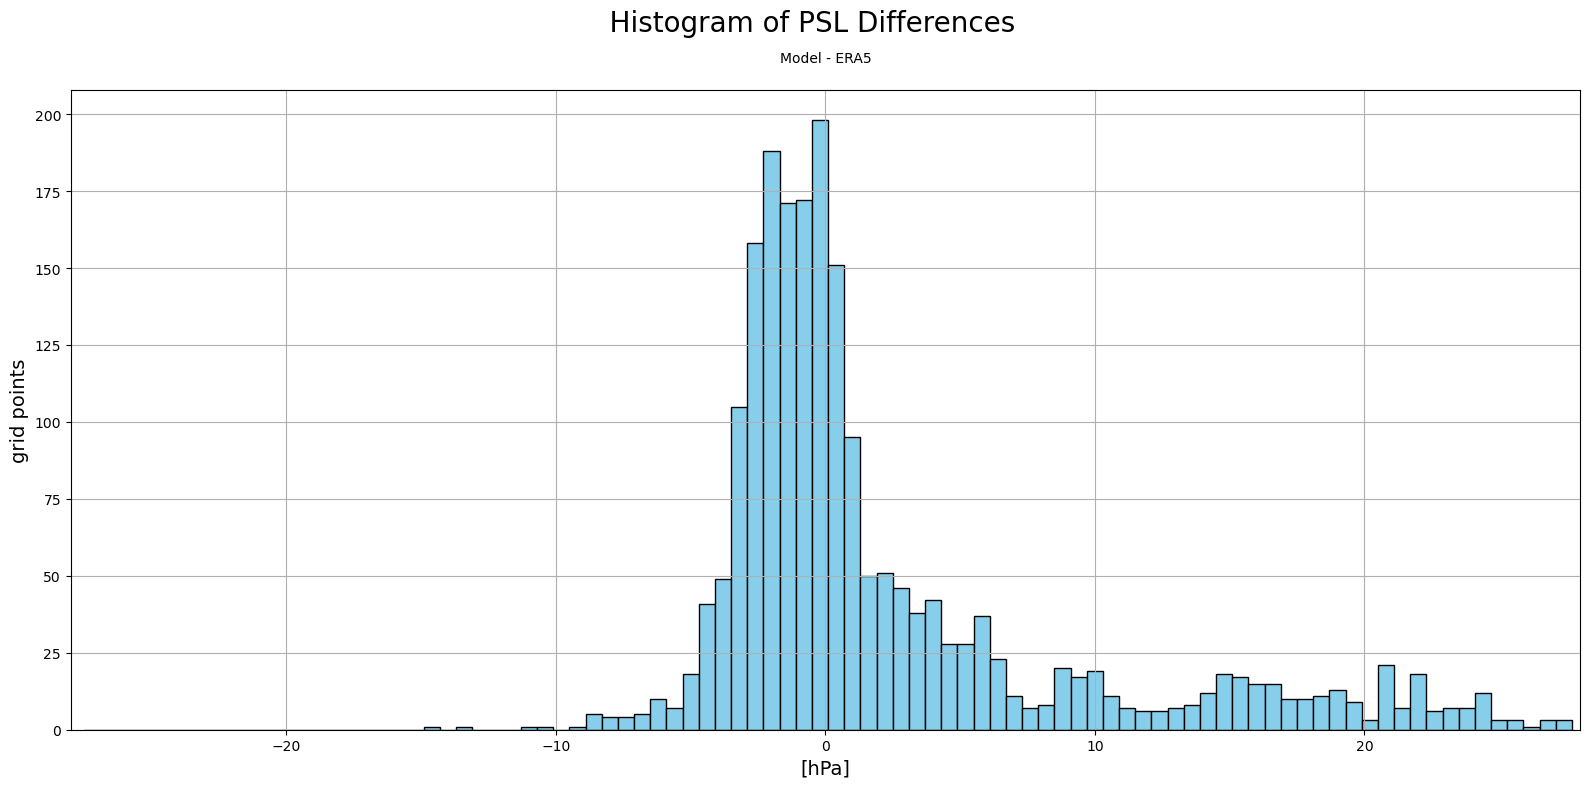

In [291]:
bins = compute_bins(0.6,slp_diff)

plt.figure(figsize=(16, 8))
plt.hist(slp_diff[~np.isnan(slp_diff)].flatten(), bins=bins, color='skyblue', edgecolor='k')
plt.suptitle('    Histogram of PSL Differences', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.xlabel("[hPa]", fontsize=14)
plt.ylabel("grid points", fontsize=14)
plt.grid(True)
plt.xlim(-28, 28)
plt.tight_layout()
plt.show()

In [149]:
compute_metrics(model=psl_climatology_model, era5=psl_climatology_era5_resampled, diff=slp_diff, name='SLP')

Metrics for SLP:
  Mean Bias Error (MBE): 2.252
  Root Mean Square Error (RMSE): 7.329
  Mean Absolute Error (MAE): 4.456
  Pearson Correlation: 0.720 with a pvalue of 0.000


### 850 hPa Zonal Wind Speed

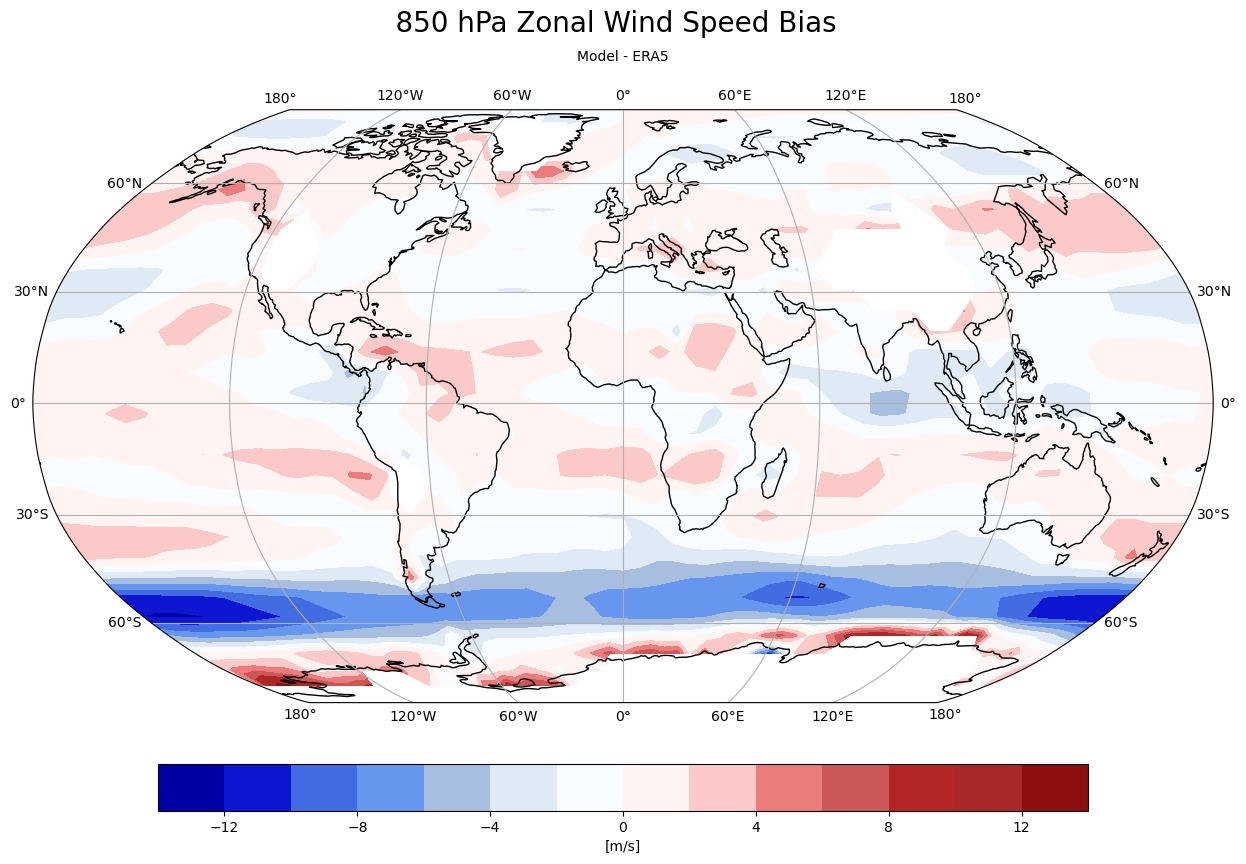

In [ ]:
u_diff = (u_850_climatology_model - u_850_climatology_era5_resampled)

# SLP bias plot
fig = plt.figure(figsize=(20, 10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()
axs.gridlines(draw_labels=True)

levels = normalize(u_diff)

crs = plt.contourf(longitude, latitude, u_diff, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap)
cbar = plt.colorbar(crs, location='bottom', shrink=0.6, pad =0.08)
cbar.set_label('[m/s]')

plt.suptitle('    850 hPa Zonal Wind Speed Bias', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.show()

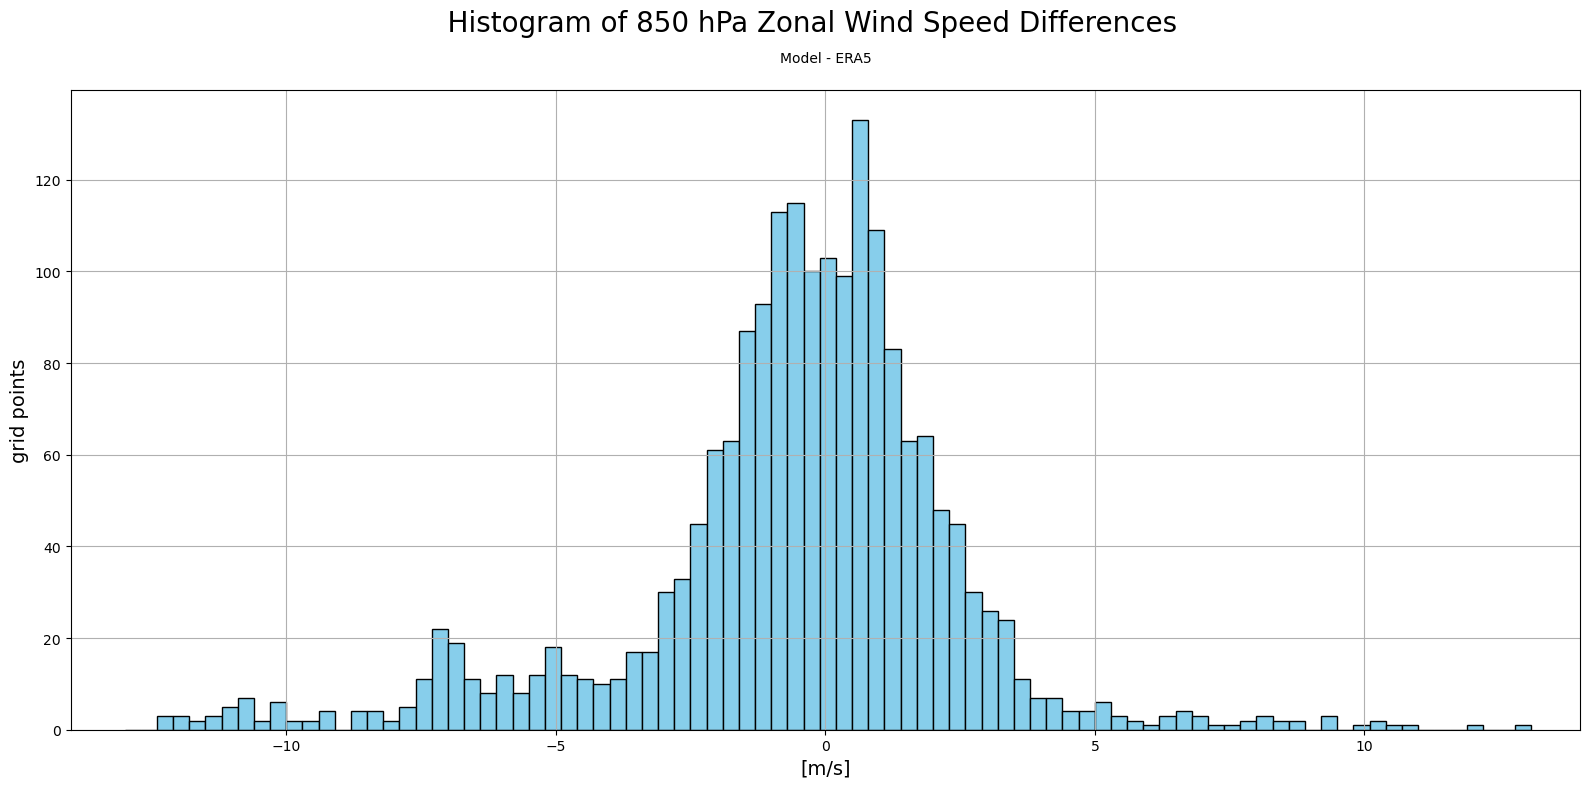

In [298]:
bins = compute_bins(0.3, u_diff)

plt.figure(figsize=(16, 8))
plt.hist(u_diff[~np.isnan(u_diff)].flatten(), bins=bins, color='skyblue', edgecolor='k')
plt.suptitle('    Histogram of 850 hPa Zonal Wind Speed Differences', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad =20, loc='center')
plt.xlabel("[m/s]", fontsize=14)
plt.ylabel("grid points", fontsize=14)
plt.grid(True)
plt.xlim(-14, 14)
plt.tight_layout()
plt.show()

In [158]:
compute_metrics(model=u_850_climatology_model, era5=u_850_climatology_era5_resampled, diff=u_diff, name='850 hPa Zonal Wind Speed')

Metrics for 850 hPa Zonal Wind Speed:
  Mean Bias Error (MBE): -0.571
  Root Mean Square Error (RMSE): 3.110
  Mean Absolute Error (MAE): 2.119
  Pearson Correlation (without NaNs): 0.827 with a pvalue of 0.000


### Sea Ice Cover

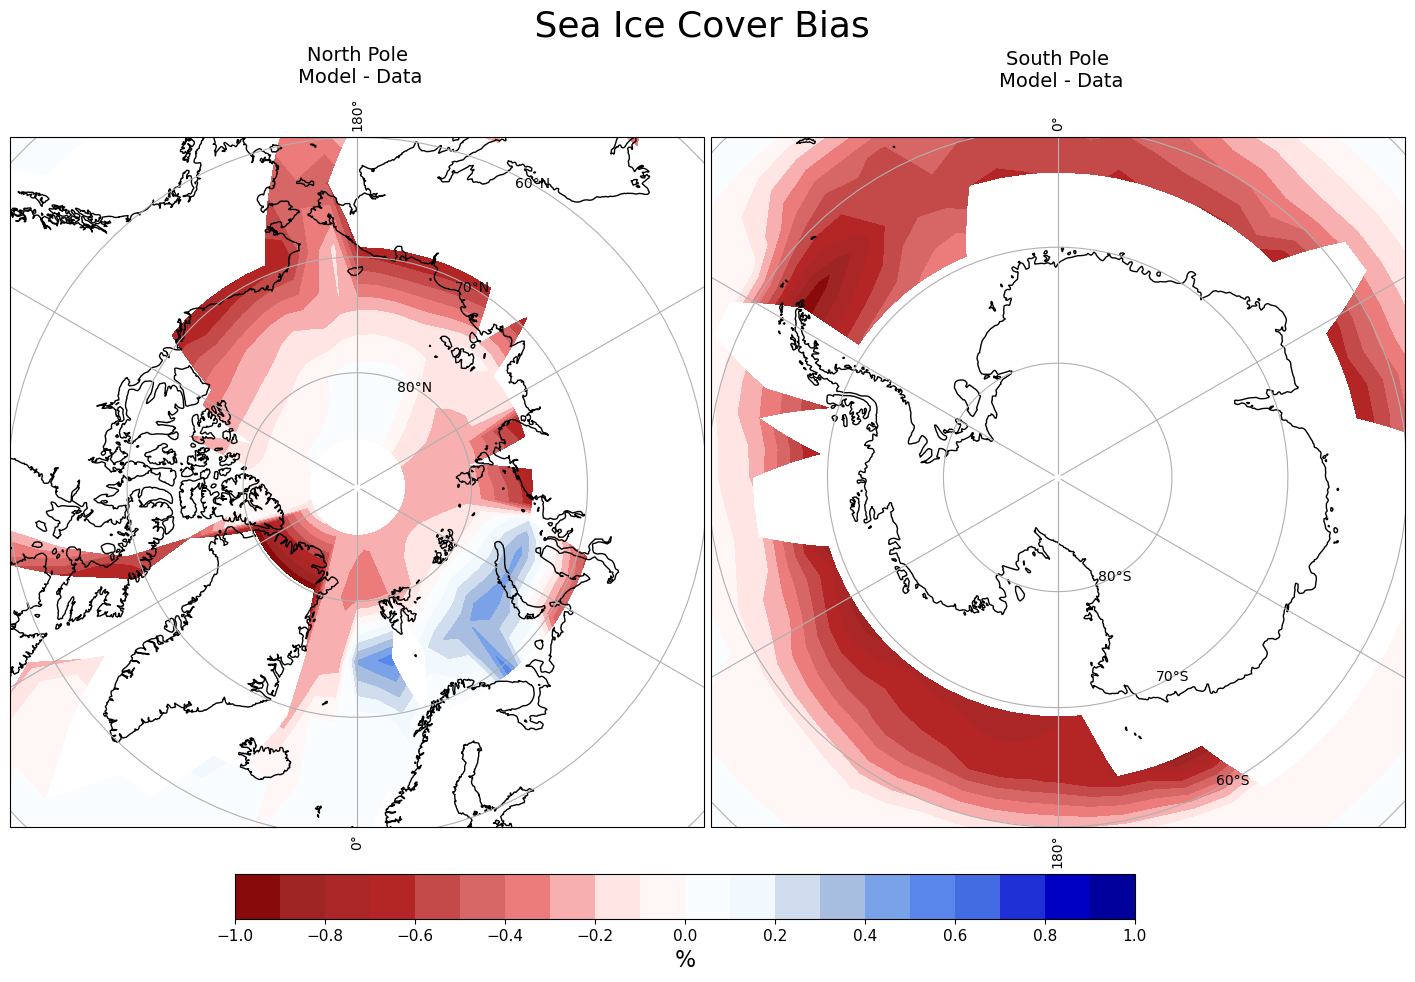

In [269]:
diff_ice = ice_cover_climatology_model - ice_cover_climatology_era5_resampled

# Define levels and boundaries
levels = np.arange(-1.0, 1.01, 0.1)
boundaries = np.arange(-1.0, 1.2, 0.2)
ticks = np.arange(-1.0, 1.2, 0.2)

fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.01)

# North Pole
ax1 = fig.add_subplot(gs[0], projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
crs1 = ax1.contourf(longitude, latitude, diff_ice, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap.reversed())
ax1.set_title('North Pole\n Model - Data', fontsize=14, pad=10)

# South Pole
ax2 = fig.add_subplot(gs[1], projection=ccrs.SouthPolarStereo())
ax2.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
crs2 = ax2.contourf(longitude, latitude, diff_ice, levels=levels, transform=ccrs.PlateCarree(), cmap=custom_cmap.reversed())
ax2.set_title('South Pole\n Model - Data', fontsize=14, pad=20)

# Colorbar
cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
cbar = fig.colorbar(crs1, cax=cbar_ax, orientation='horizontal', boundaries=boundaries, ticks=ticks)
cbar.set_label('%', fontsize =16)
cbar.ax.tick_params(labelsize=11)

# Title
fig.suptitle('   Sea Ice Cover Bias', fontsize=26, y=1.02)

plt.show()

In [199]:
lon2d, lat2d = np.meshgrid(longitude, latitude)  # Now lat2d is 2D
north_mask = lat2d >= 60
south_mask = lat2d <= -60

diff_ice_north = np.where(north_mask, diff_ice, np.nan)
diff_ice_south = np.where(south_mask, diff_ice, np.nan)

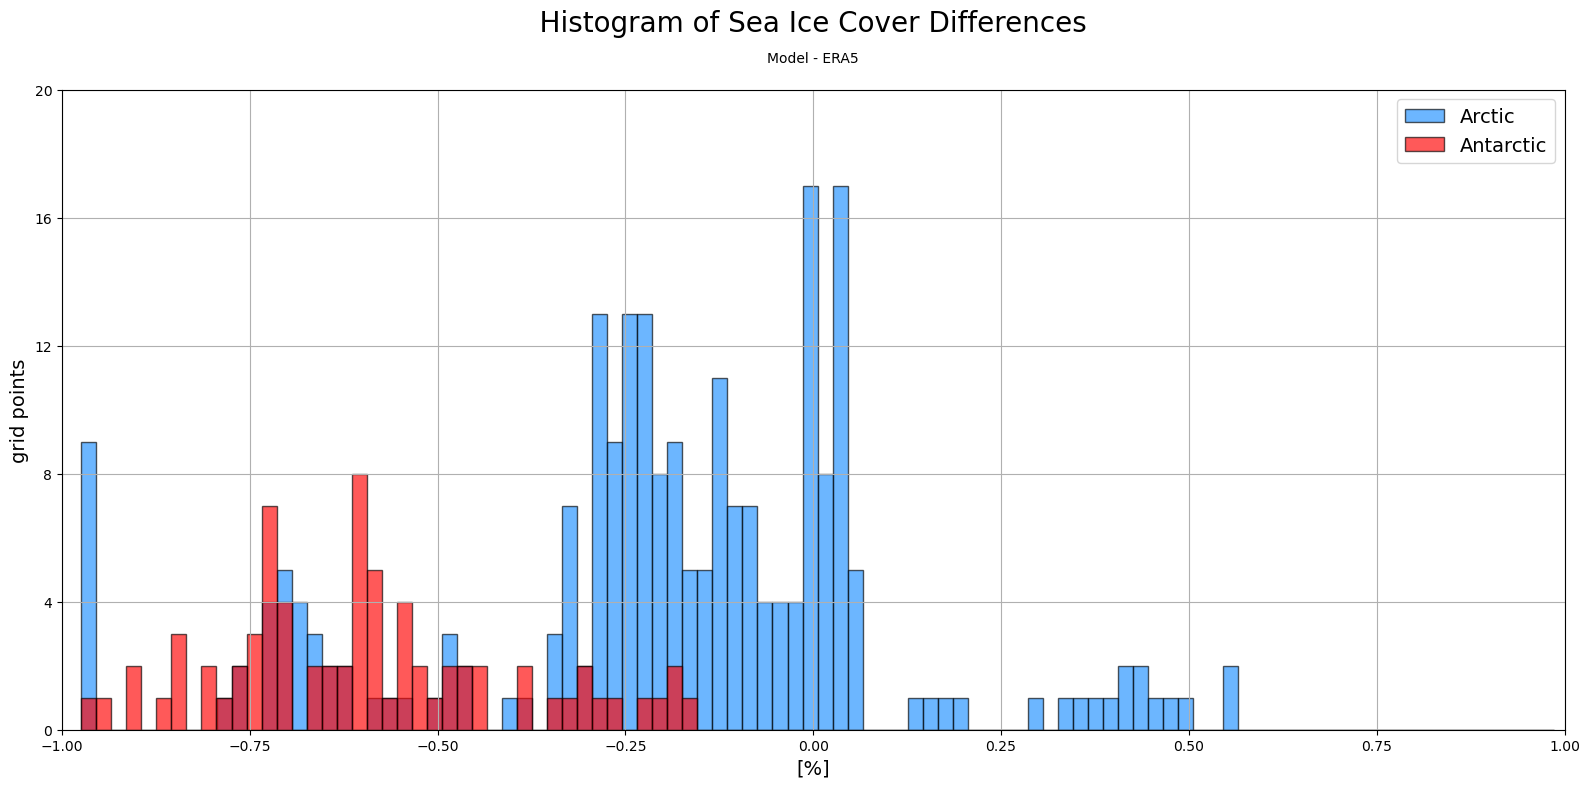

In [303]:
bins_north = compute_bins(0.02, diff_ice_north)
bins_south = compute_bins(0.02, diff_ice_south)

plt.figure(figsize=(16, 8))
plt.hist(diff_ice_north[~np.isnan(diff_ice_north)].flatten(), bins=bins_north, color='dodgerblue', edgecolor='k', alpha=0.65, label='Arctic')
plt.hist(diff_ice_south[~np.isnan(diff_ice_south)].flatten(), bins=bins_south, color='red', edgecolor='k', alpha=0.65, label='Antarctic')
plt.suptitle('    Histogram of Sea Ice Cover Differences', fontsize=20)
plt.title('Model - ERA5', fontsize=10, pad=20, loc='center')
plt.xlabel("[%]", fontsize=14)
plt.ylabel("grid points", fontsize=14)
plt.grid(True)
plt.xlim(-1, 1)
plt.yticks(np.arange(0, 21, 4))
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


In [310]:
compute_metrics(model=ice_cover_climatology_model[north_mask], era5=ice_cover_climatology_era5_resampled[north_mask],
    diff=diff_ice[north_mask],
    name='Arctic Sea Ice Cover'
)

Metrics for Arctic Sea Ice Cover:
  Mean Bias Error (MBE): -0.201
  Root Mean Square Error (RMSE): 0.364
  Mean Absolute Error (MAE): 0.267
  Pearson Correlation (without NaNs): 0.609 with a pvalue of 0.000


In [311]:
compute_metrics(model=ice_cover_climatology_model[south_mask], era5=ice_cover_climatology_era5_resampled[south_mask],
    diff=diff_ice[south_mask],
    name='Antarctic Sea Ice Cover'
)

Metrics for Antarctic Sea Ice Cover:
  Mean Bias Error (MBE): -0.595
  Root Mean Square Error (RMSE): 0.625
  Mean Absolute Error (MAE): 0.595
  Pearson Correlation (without NaNs): 0.455 with a pvalue of 0.000
